In [53]:
import matplotlib.pyplot as plt
import numpy as np
from diffractio import um, np
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
import cupy as cp
import cupyx as cpx
%matplotlib ipympl

In [54]:
import cupy as cp
from cupyx.scipy.interpolate import interpn
def value_func_2d(x, y):
    return 2 * x + 3 * y
x = cp.linspace(0, 4, 5)
y = cp.linspace(0, 5, 6)
points = (x, y)
values = value_func_2d(*cp.meshgrid(*points, indexing='ij'))

point = cp.array([2.21, 3.12])
print(interpn(points, values, point))

[13.78]


In [55]:
# FFT method to solve diffraction at aperture
def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.circle(r0=(0 * um, 0 * um), radius=(aperture_width / 2 * um, aperture_width / 2 * um), angle=0)
    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2, t0


In [56]:
# Cupy method
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=18*1024**3)

def monte_carlo_diffraction_cupy_2D(N_total, 
                                    final_image_real,
                                    final_image_imag,
                                    source_width_x,
                                    source_width_y,
                                    sample_phase_shift,
                                    det_yx,
                                    z_prop,
                                    wavelength,
                                    batch_size=int(1e7)):  # Batch size of rays to GPU
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]

    # Pdf to normalise ray amplitudes at beginning - for plane wave this is a constant for all rays
    pdf = 1 / (source_width_x * source_width_y)
    # Wavenumber
    k = 2 * np.pi / wavelength
    
    # Initialize arrays to count the number of rays per pixel
    counts = cp.zeros((y_det, x_det), dtype=cp.int32)
    for start_idx in range(0, N_total, batch_size):
        end_idx = min(start_idx + batch_size, N_total)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source and the detector
        source_x = cp.random.uniform(-source_width_x/2, source_width_x/2, size=current_batch_size)
        source_y = cp.random.uniform(-source_width_y/2, source_width_y/2, size=current_batch_size)
        source_z = cp.zeros(current_batch_size)
        
        sample_phase_shifts = sample_phase_shift((source_x, source_y))
        
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        # Find counts of rays on detector
        cp.add.at(counts, (rand_det_idx_y, rand_det_idx_x), 1)

        # Organise coordinats on detector that rays hit
        # z y x is the ordering of coordinates
        det_x = det_yx[1, rand_det_idx_y, rand_det_idx_x]
        det_y = det_yx[0, rand_det_idx_y, rand_det_idx_x]
        det_z = cp.ones(current_batch_size) * z_prop

        # Convert coordinates to a vector for computation
        ray_source_coord = cp.array([source_z, source_y, source_x])
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_distance = cp.linalg.norm(ray, axis = 0)

        
        wave_function = 1 + 0j #np.abs(np.random.uniform(0, 1)) * np.exp(1j * 0)
        sample = sample_phase_shifts
        rayleigh_sommerfeld_terms = (sample * wave_function) * np.exp(1j * k * (ray_distance)) / ray_distance * (z_prop / ray_distance) * (1j * k)
        
        # Get amplitude and phase of all rays
        # amplitude =  (1 / ray_distance) * (1 / (2 * np.pi)) * (1j * k * z_prop / ray_distance) / pdf * np.exp(1j * sample_phase_shifts)
        # phase_propagation = k * ray_distance
        

        # phase_sample = sample_phase_shifts
        
        # Get diffraction field at detector by summing the point sources from the aperture. 
        # complex_rays = amplitude * (np.exp(1j * phase_propagation)) * np.exp(1j * k * z_prop)

        complex_rays = rayleigh_sommerfeld_terms
        
        # Add complex wavefront to each pixel in the image
        cpx.scatter_add(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cpx.scatter_add(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)
    
    # Add ampliude and phase together
    final_image = (1 / 2 * np.pi) * (final_image_real + 1j * final_image_imag)
    
    # Divide each pixel that a ray has hit by the number of counts
    non_zero_counts = counts > 0
    final_image[non_zero_counts] *= 1 / counts[non_zero_counts]
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image, ray_source_coord, ray_det_coord

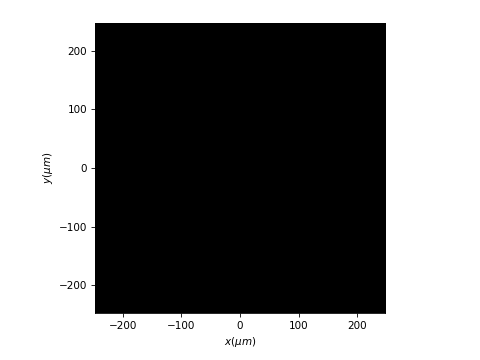

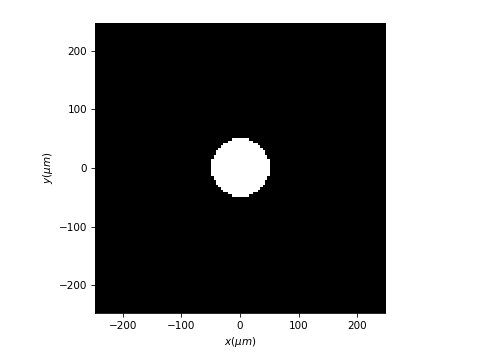

In [57]:
# Set up coordinates
aperture_diameter = 100 * um
detector_width_x = 500 * um
detector_width_y = 500 * um

# Define number of pixels on detector
num_px_det_x = 125
num_px_det_y  = 125

# Set detector width
detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

# Formd the detector coordinates matrix
det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)

# Define propagation distance after aperture
z_prop = 500 * um

# Set wavelength
wavelength = 1 * um

# Find diffraction from aperture using fourier transform integration of rayleigh sommerfeld diffraction integral
u2, t0 = diffractio_rs_aperture_2D(x0=det_yx_coords[1, 0, :], y0=det_yx_coords[1, 0, :],
                                z_prop=z_prop, 
                                wavelength=wavelength,
                                aperture_width=aperture_diameter, 
                                draw_inputs=True)



In [58]:
from cupyx.scipy.interpolate import RegularGridInterpolator

# Choose number of rays
num_rays=int(1e10)

# Set source area
source_width_x = detector_width_x
source_width_y = detector_width_y

# Make cupy arrays
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

aperture_mask = cp.abs(cp.asarray(t0.u) ** 2).astype(cp.int32)

sample_interp = RegularGridInterpolator((det_yx_coords[1, 0, :], det_yx_coords[1, 0, :]), aperture_mask, bounds_error=False, fill_value=None)

# plt.figure()
# plt.imshow(sample_interp([det_yx_coords[0, :, :], det_yx_coords[1, :, :]]))

final_image, ray_aper_coord, ray_det_coord = monte_carlo_diffraction_cupy_2D(num_rays, 
                                                                            final_image_real,
                                                                            final_image_imag,
                                                                            source_width_x,
                                                                            source_width_y,
                                                                            sample_phase_shift=sample_interp,
                                                                            det_yx=det_yx_coords,
                                                                            z_prop=z_prop,
                                                                            wavelength=wavelength,
                                                                            batch_size=int(1e7),
                                                                            )
# Convery back to numpy for plotting
det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)
ray_aper_coord = cp.asnumpy(ray_aper_coord)
ray_det_coord = cp.asnumpy(ray_det_coord)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


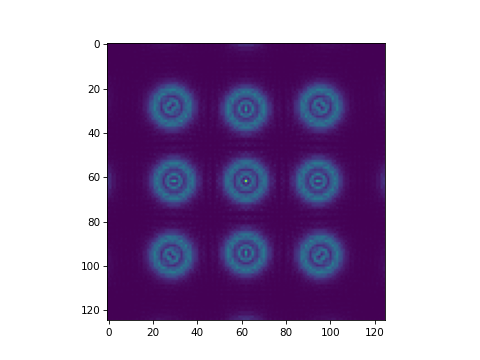

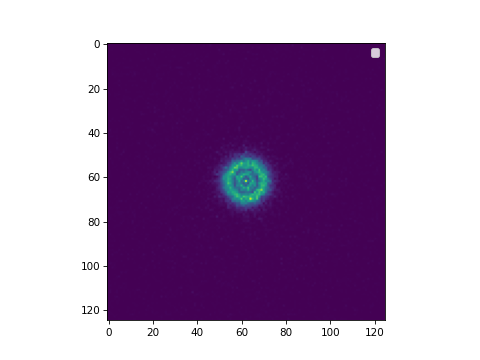

In [59]:
# Plotting
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Fourier Integration RayLeigh Sommerfeld')

fig, ax = plt.subplots()
ax.imshow(np.abs(final_image) ** 2, label='Monte Carlo Integration RayLeigh Sommerfeld')
plt.legend()

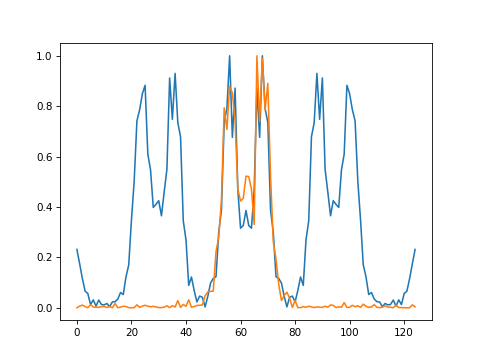

In [60]:
# Plot cross section. 
plt.figure()
plt.plot(np.abs(u2.u[67, :]) ** 2 / np.max(np.abs(u2.u[67, :]) ** 2))
plt.plot(np.abs(final_image[67, :]) ** 2 / np.max(np.abs(final_image[67, :]) ** 2))

[                                        ] | 0% Completed | 183.40 us

[########################################] | 100% Completed | 101.23 ms


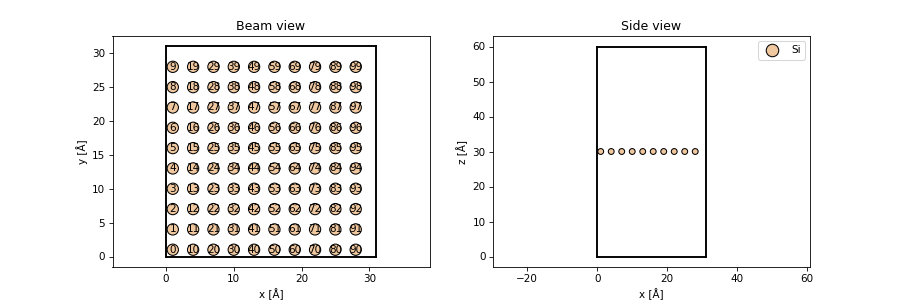

In [61]:
import ase
import abtem
import matplotlib.pyplot as plt

PHI_0 = 100e3

num_atoms_x = 10 
num_atoms_y = 10
atom_spacing = 3.0
x_start = 1.0
y_start = 1.0

z_start = 60
z_atoms = 30

# Create an empty Atoms object
atoms = ase.Atoms('Si0', cell=[x_start + num_atoms_x* atom_spacing, y_start + num_atoms_y* atom_spacing, z_start])

# Adding atoms in a row
for i in range(num_atoms_x):
    for j in range(num_atoms_y):
        x_position = x_start + i * atom_spacing
        y_position = y_start + j * atom_spacing
        atoms += ase.Atoms('Si1', positions=[(x_position, y_position, z_atoms)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.4, projection="infinite", slice_thickness=30)
potential_array = potential.build().project().compute()


[########################################] | 100% Completed | 100.97 ms


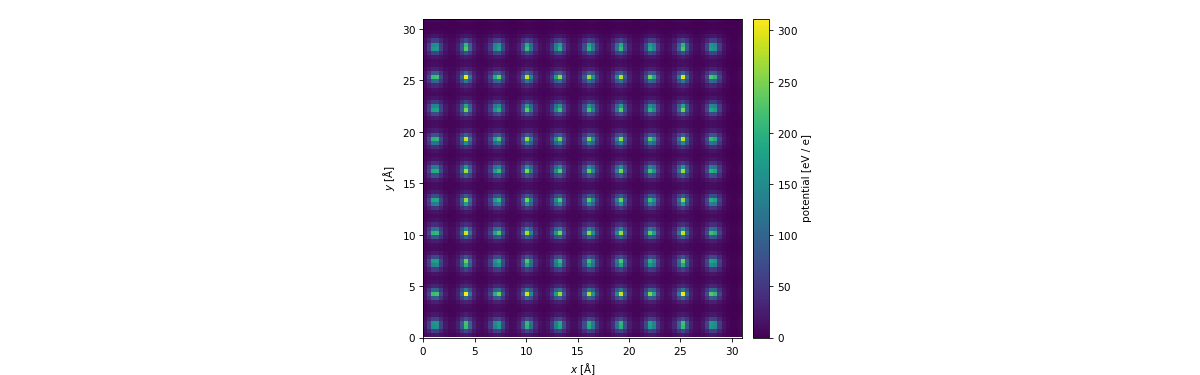

In [62]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [63]:
plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 100.94 ms


In [64]:
from abtem.core.energy import energy2sigma, energy2wavelength

PHI_0 = 100e3
sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

# Formd the detector coordinates matrix
det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_yx_coords = det_yx_coords.T.reshape(2, num_px_y, num_px_x)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shifts = (potential_array.array * sigma)

print(num_px_x, num_px_y)


78 78


In [65]:
# Choose number of rays
num_rays=int(1e10)

# Set source area
source_width_x = detector_width_x
source_width_y = detector_width_y

# Make cupy arrays
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_y, num_px_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_y, num_px_x], dtype=cp.float64)
sample_phase_shifts = cp.asarray(sample_phase_shifts)

sample_interp = RegularGridInterpolator((det_yx_coords[1, 0, :], det_yx_coords[1, 0, :]), sample_phase_shifts, bounds_error=False, fill_value=None)
# print(sample_interp([0, 0]))
z_prop = z_atoms
final_image, ray_aper_coord, ray_det_coord = monte_carlo_diffraction_cupy_2D(num_rays, 
                                                                            final_image_real,
                                                                            final_image_imag,
                                                                            source_width_x,
                                                                            source_width_y,
                                                                            sample_phase_shift=sample_interp,
                                                                            det_yx=det_yx_coords,
                                                                            z_prop=z_prop,
                                                                            wavelength=wavelength,
                                                                            batch_size=int(5e7),
                                                                            )
# Convery back to numpy for plotting
det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)
ray_aper_coord = cp.asnumpy(ray_aper_coord)
ray_det_coord = cp.asnumpy(ray_det_coord)


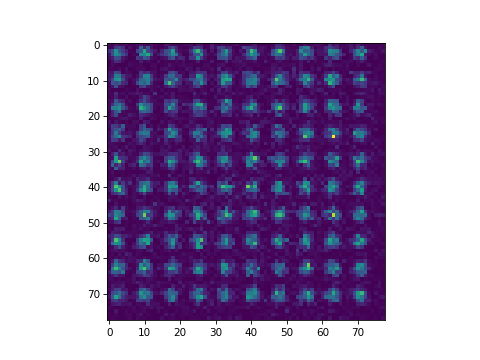

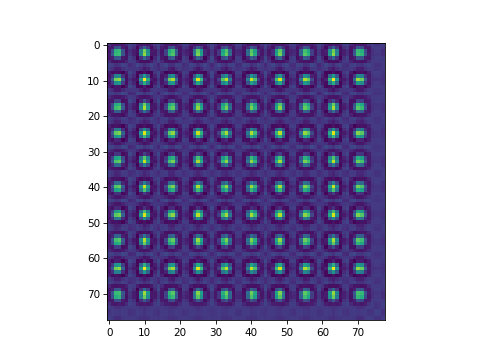

: 

In [66]:
# Plot cross section. 
plt.figure()
plt.imshow(np.abs(final_image) ** 2)

plt.figure()
plt.imshow(np.abs(complex_image.array)**2)